# COVID19 Global Forecasting (Week 5)

## Problem Statement

In this challenge, you will be predicting the daily number of confirmed COVID19 cases in various locations across the world, as well as the number of resulting fatalities, for future dates. This latest challenge includes US state county data.

## Data 

* This evaluation data for this competition comes from John Hopkins CSSE, which is uninvolved in the competition.
* See their README for a description of how the data was collected.
* They are currently updating the data daily.

## Solution

### Libraries

In [4]:
# Standard libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import time




# Libraries for EDA and preprocessing 
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# libraies for Model 
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# libraries for Evaluations
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [5]:
### Load data to variables 

train_data = pd.read_csv('Datasets/covid19-global-forecasting-week-5/train.csv')
test_data = pd.read_csv('Datasets/covid19-global-forecasting-week-5/test.csv')

In [6]:
# print the first 2 rows of train_data 

train_data.head(2)

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0


In [7]:
# print the first two rows of test_data

test_data.head(2)

,ForecastId,County,Province_State,Country_Region,Population,Weight,Date,Target
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-27,ConfirmedCases
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-27,Fatalities


### EDA and preprocessing

In [8]:
# Information about train_data 

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754934 entries, 0 to 754933
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              754934 non-null  int64  
 1   County          685174 non-null  object 
 2   Province_State  714168 non-null  object 
 3   Country_Region  754934 non-null  object 
 4   Population      754934 non-null  int64  
 5   Weight          754934 non-null  float64
 6   Date            754934 non-null  object 
 7   Target          754934 non-null  object 
 8   TargetValue     754934 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 51.8+ MB


**Our train_data contains 9 features which contains 1 int value, 5 object values, and 2 float values**

In [9]:
# size of our data set 

train_data.shape # Contains 754934 data

(754934, 9)

In [10]:
# check for any null values in our train data set 

train_data.isna().sum()

Id                    0
County            69760
Province_State    40766
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64

**We can see that our train_data has null values in following columns with respective numbers:**
    
* County      with      69760
* Province_State   with 40766

In [11]:

# lets check the information about test_data 

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311670 entries, 0 to 311669
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ForecastId      311670 non-null  int64  
 1   County          282870 non-null  object 
 2   Province_State  294840 non-null  object 
 3   Country_Region  311670 non-null  object 
 4   Population      311670 non-null  int64  
 5   Weight          311670 non-null  float64
 6   Date            311670 non-null  object 
 7   Target          311670 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 19.0+ MB


**Test data contains all the columns  in train_data except for Target_values, It contains float64(1), int64(2), object(5)**

In [12]:
# find if there is any null value in the test data set 

test_data.isna().sum()

ForecastId            0
County            28800
Province_State    16830
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
dtype: int64

**Test data also contains 28800 null values of county and 16830 values of Provice_state**

In [13]:
# Remove the null value data from our train_data set 

train_data.drop(['Id', 'County', 'Province_State'], axis = 1, inplace = True)
train_data.head()


,Country_Region,Population,Weight,Date,Target,TargetValue
0,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0


In [14]:
# Remove the null value data from our test_data set 
test_data.drop(['ForecastId','County', 'Province_State'], axis =1, inplace = True )
test_data.head()

,Country_Region,Population,Weight,Date,Target
0,Afghanistan,27657145,0.058359,2020-04-27,ConfirmedCases
1,Afghanistan,27657145,0.583587,2020-04-27,Fatalities
2,Afghanistan,27657145,0.058359,2020-04-28,ConfirmedCases
3,Afghanistan,27657145,0.583587,2020-04-28,Fatalities
4,Afghanistan,27657145,0.058359,2020-04-29,ConfirmedCases


In [15]:
# Check if there any null values present in train_data 

train_data.isna().sum()

Country_Region    0
Population        0
Weight            0
Date              0
Target            0
TargetValue       0
dtype: int64

In [16]:
train_data.describe()

,Population,Weight,TargetValue
count,7.549340e+05,754934.000000,754934.000000
mean,2.719395e+06,0.530872,9.746414
std,3.477762e+07,0.451909,261.845643
min,8.600000e+01,0.047491,-10034.000000
25%,1.213300e+04,0.096838,0.000000
50%,3.053100e+04,0.349413,0.000000
75%,1.056120e+05,0.968379,0.000000
max,1.395773e+09,2.239186,36163.000000


In [17]:
# lets count the target values 

train_data['Target'].value_counts()

ConfirmedCases    377467
Fatalities        377467
Name: Target, dtype: int64

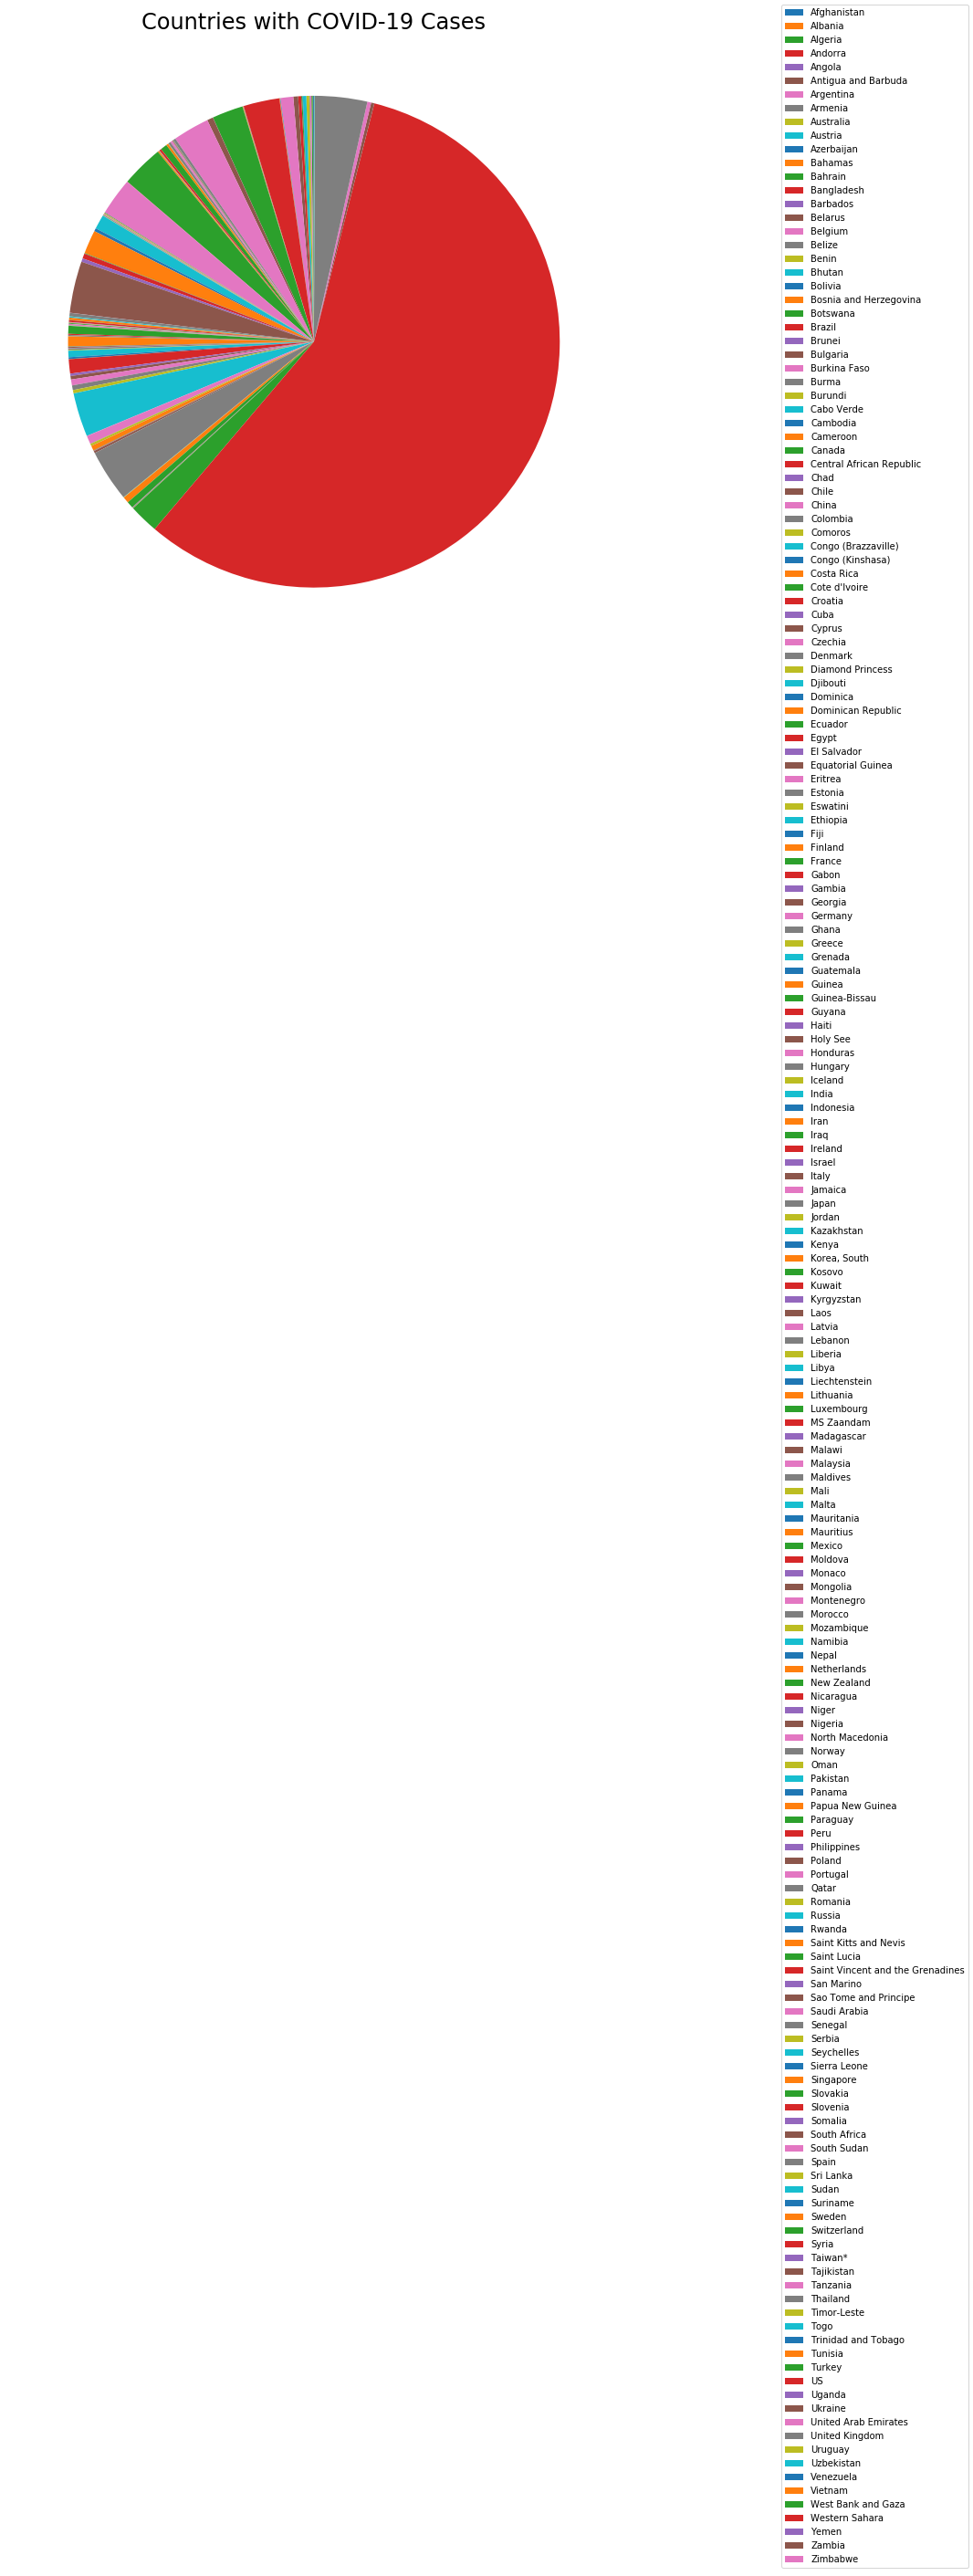

In [18]:

fig, ax= plt.subplots(figsize = (20,10))
ax.pie(x=train_data.groupby(by=["Country_Region"])["TargetValue"].sum(), startangle=90)
label =train_data['Country_Region'].unique()
plt.title("Countries with COVID-19 Cases", fontsize = 24) 
fig.legend(label) 
plt.tight_layout() 
plt.show()

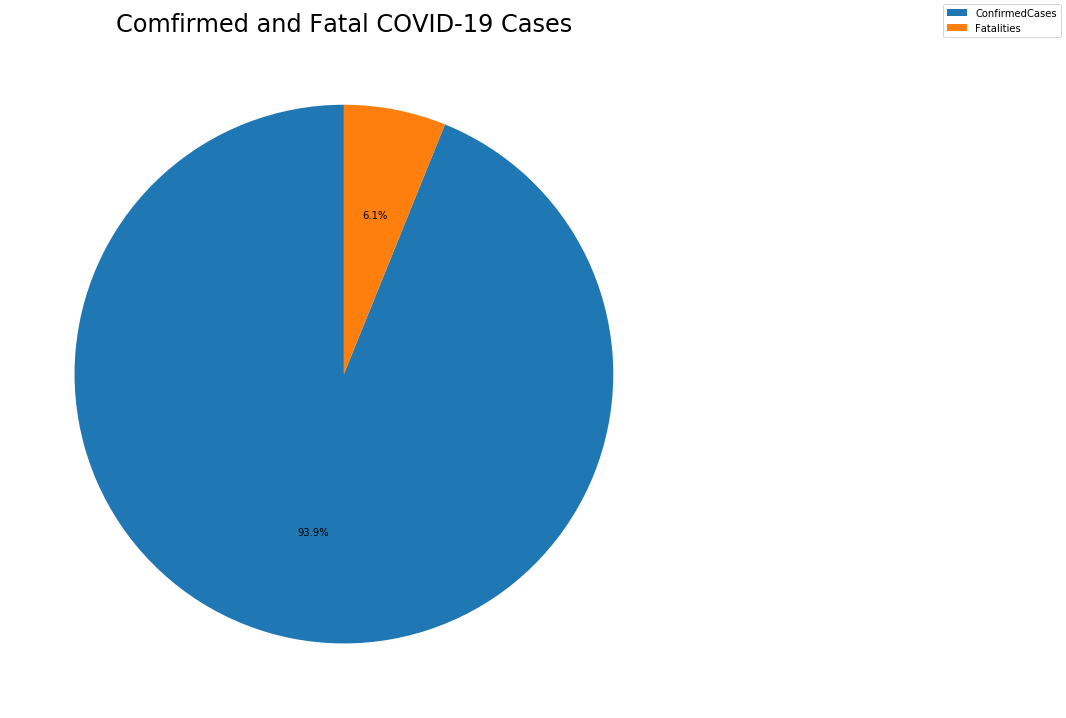

In [19]:
# visualization of comfirmed and fatal cases
fig, ax= plt.subplots(figsize = (20,10))
ax.pie(x=train_data.groupby(by=["Target"])["TargetValue"].sum(), autopct='%1.1f%%', startangle=90)
label =train_data['Target'].unique()
plt.title("Comfirmed and Fatal COVID-19 Cases", fontsize = 24) 
fig.legend(label) 
plt.tight_layout() 
plt.show()

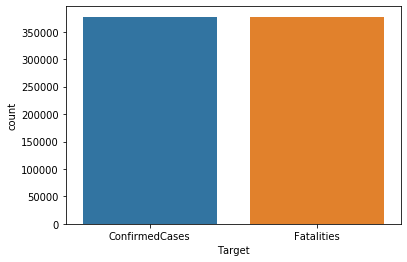

In [20]:
sns.countplot(x ='Target', data = train_data);

In [21]:
# Finding the latest case in the countries
last_date = train_data.Date.max()
df=train_data[train_data["Date"]==last_date]
df

,Country_Region,Population,Weight,Date,Target,TargetValue
216,Afghanistan,27657145,0.058359,2020-05-10,ConfirmedCases,369.0
217,Afghanistan,27657145,0.583587,2020-05-10,Fatalities,5.0
434,Albania,2886026,0.067225,2020-05-10,ConfirmedCases,12.0
435,Albania,2886026,0.672251,2020-05-10,Fatalities,0.0
652,Algeria,40400000,0.057096,2020-05-10,ConfirmedCases,165.0
...,...,...,...,...,...,...
754497,Yemen,28500000,0.582567,2020-05-10,Fatalities,1.0
754714,Zambia,15933883,0.060299,2020-05-10,ConfirmedCases,15.0
754715,Zambia,15933883,0.602992,2020-05-10,Fatalities,0.0
754932,Zimbabwe,14240168,0.060711,2020-05-10,ConfirmedCases,1.0


In [22]:
# calculating the sum of targetvalue of country region
df=df.groupby(by=["Country_Region"],as_index=False)["TargetValue"].sum()
df

,Country_Region,TargetValue
0,Afghanistan,374.0
1,Albania,12.0
2,Algeria,173.0
3,Andorra,1.0
4,Angola,2.0
...,...,...
182,West Bank and Gaza,0.0
183,Western Sahara,0.0
184,Yemen,18.0
185,Zambia,15.0


In [23]:
# 5 countries with large target value.
countries = df.nlargest(5,"TargetValue")
countries

,Country_Region,TargetValue
173,US,60544.0
139,Russia,11100.0
23,Brazil,7105.0
79,India,4464.0
177,United Kingdom,4192.0


In [24]:
cases=train_data.groupby(by=["Date","Country_Region"],as_index=False)["TargetValue"].sum()
cases

,Date,Country_Region,TargetValue
0,2020-01-23,Afghanistan,0.0
1,2020-01-23,Albania,0.0
2,2020-01-23,Algeria,0.0
3,2020-01-23,Andorra,0.0
4,2020-01-23,Angola,0.0
...,...,...,...
20378,2020-05-10,West Bank and Gaza,0.0
20379,2020-05-10,Western Sahara,0.0
20380,2020-05-10,Yemen,18.0
20381,2020-05-10,Zambia,15.0


In [25]:
cases=cases.merge(countries,on="Country_Region")
cases

,Date,Country_Region,TargetValue_x,TargetValue_y
0,2020-01-23,Brazil,0.0,7105.0
1,2020-01-24,Brazil,0.0,7105.0
2,2020-01-25,Brazil,0.0,7105.0
3,2020-01-26,Brazil,0.0,7105.0
4,2020-01-27,Brazil,0.0,7105.0
...,...,...,...,...
540,2020-05-06,United Kingdom,6765.0,4192.0
541,2020-05-07,United Kingdom,6157.0,4192.0
542,2020-05-08,United Kingdom,5279.0,4192.0
543,2020-05-09,United Kingdom,4242.0,4192.0


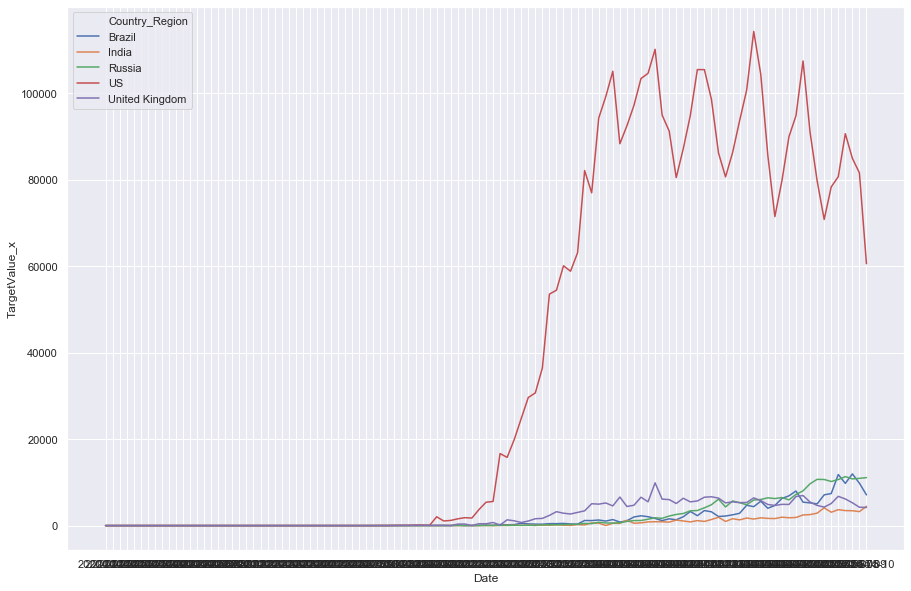

In [26]:
# visualization of the target value with the country
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
sns.lineplot(x="Date",y="TargetValue_x",hue="Country_Region",data=cases);

In [27]:
# finding the correlation 
train_data.corr()

,Population,Weight,TargetValue
Population,1.000000,-0.039869,0.127156
Weight,-0.039869,1.000000,-0.036102
TargetValue,0.127156,-0.036102,1.000000


In [28]:
train_data.drop(["Target"],inplace=True,axis=1)
test_data.drop(["Target"],inplace=True,axis=1)
train_data

,Country_Region,Population,Weight,Date,TargetValue
0,Afghanistan,27657145,0.058359,2020-01-23,0.0
1,Afghanistan,27657145,0.583587,2020-01-23,0.0
2,Afghanistan,27657145,0.058359,2020-01-24,0.0
3,Afghanistan,27657145,0.583587,2020-01-24,0.0
4,Afghanistan,27657145,0.058359,2020-01-25,0.0
...,...,...,...,...,...
754929,Zimbabwe,14240168,0.607106,2020-05-08,0.0
754930,Zimbabwe,14240168,0.060711,2020-05-09,1.0
754931,Zimbabwe,14240168,0.607106,2020-05-09,0.0
754932,Zimbabwe,14240168,0.060711,2020-05-10,1.0


In [29]:
# transform the country_region variable

lab = LabelEncoder()
train_data['Country_Region'] = lab.fit_transform(train_data['Country_Region'])
train_data.head()

,Country_Region,Population,Weight,Date,TargetValue
0,0,27657145,0.058359,2020-01-23,0.0
1,0,27657145,0.583587,2020-01-23,0.0
2,0,27657145,0.058359,2020-01-24,0.0
3,0,27657145,0.583587,2020-01-24,0.0
4,0,27657145,0.058359,2020-01-25,0.0


In [30]:
test_data['Country_Region'] = lab.fit_transform(test_data['Country_Region'])

In [31]:
test_data.head()

,Country_Region,Population,Weight,Date
0,0,27657145,0.058359,2020-04-27
1,0,27657145,0.583587,2020-04-27
2,0,27657145,0.058359,2020-04-28
3,0,27657145,0.583587,2020-04-28
4,0,27657145,0.058359,2020-04-29


In [32]:
train_data.Date=train_data.Date.apply(lambda x:x.split("-"))

In [33]:
test_data.Date=test_data.Date.apply(lambda x:x.split("-"))

In [34]:
# split Date into month and day 

def monthday(data):
    month = []
    day= []
    for date in data.Date:
        month.append(int(date[1]))
        day.append(int(date[2]))
    data['month'] = month
    data['day'] = day
    data = data.drop('Date', axis =1 )
    return data 

In [35]:
train_data = monthday(train_data)
test_data = monthday(test_data)
train_data.head()

,Country_Region,Population,Weight,TargetValue,month,day
0,0,27657145,0.058359,0.0,1,23
1,0,27657145,0.583587,0.0,1,23
2,0,27657145,0.058359,0.0,1,24
3,0,27657145,0.583587,0.0,1,24
4,0,27657145,0.058359,0.0,1,25


### Modelling

In [36]:
# Split data into  y
scaler = MinMaxScaler()


y = train_data['TargetValue'].values
train_data.drop(['TargetValue'], axis = 1, inplace = True)

In [37]:
train_data.head()

,Country_Region,Population,Weight,month,day
0,0,27657145,0.058359,1,23
1,0,27657145,0.583587,1,23
2,0,27657145,0.058359,1,24
3,0,27657145,0.583587,1,24
4,0,27657145,0.058359,1,25


In [38]:
# Transforming features by scaling each feature to a given range.
X = scaler.fit_transform(train_data)
X

array([[0.        , 0.01981486, 0.00495869, 0.        , 0.73333333],
       [0.        , 0.01981486, 0.24460359, 0.        , 0.73333333],
       [0.        , 0.01981486, 0.00495869, 0.        , 0.76666667],
       ...,
       [1.        , 0.01020229, 0.25533457, 1.        , 0.26666667],
       [1.        , 0.01020229, 0.00603179, 1.        , 0.3       ],
       [1.        , 0.01020229, 0.25533457, 1.        , 0.3       ]])

In [39]:
# initialize the xgb
xgb = XGBRegressor()

In [40]:
# perform the measure
performance = cross_val_score(xgb, X, y, cv=10, scoring ='neg_mean_absolute_error', n_jobs = -1)

mae = -performance

In [41]:
mae

array([293.68704539,   6.31976653,   3.83518708,   1.79967004,
         5.29977605,   5.20830311,  11.1166884 ,   3.2386082 ,
         2.81243532,  32.12091928])

In [42]:
mae.mean()

36.543839940297076

In [43]:
# transform the test data 

test_data= scaler.fit_transform(test_data)
test_data

array([[0.        , 0.01981486, 0.00495869, 0.        , 0.86666667],
       [0.        , 0.01981486, 0.24460359, 0.        , 0.86666667],
       [0.        , 0.01981486, 0.00495869, 0.        , 0.9       ],
       ...,
       [1.        , 0.01020229, 0.25533457, 1.        , 0.26666667],
       [1.        , 0.01020229, 0.00603179, 1.        , 0.3       ],
       [1.        , 0.01020229, 0.25533457, 1.        , 0.3       ]])

In [44]:
xgb.fit(X,y)
prediction = xgb.predict(test_data)
prediction = np.around(prediction)
prediction

[17:09:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([-10.,  -6., -10., ..., -25., 165., -25.], dtype=float32)

In [48]:
xgb_1500=XGBRegressor(n_estimators=1500,max_depth=15)

In [51]:
xgb_1500.fit(X,y)


[18:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
prediction=xgb_1500.predict(test_data)
prediction=np.around(prediction)
prediction

In [ ]:
submission=pd.read_csv("Datasets/covid19-global-forecasting-week-5/submission.csv")
submission.head()

In [ ]:
test_copy=pd.read_csv('Datasets/covid19-global-forecasting-week-5/test.csv')

In [ ]:
output = pd.DataFrame({'Id': test_copy.ForecastId  , 'TargetValue': prediction})
output.head()

In [ ]:
a=output.groupby(['Id'])['TargetValue'].quantile(q=0.05).reset_index()
b=output.groupby(['Id'])['TargetValue'].quantile(q=0.5).reset_index()
c=output.groupby(['Id'])['TargetValue'].quantile(q=0.95).reset_index()

In [ ]:
a.columns=['Id','q0.05']
b.columns=['Id','q0.5']
c.columns=['Id','q0.95']
a=pd.concat([a,b['q0.5'],c['q0.95']],1)
a['q0.05']=a['q0.05']
a['q0.5']=a['q0.5']
a['q0.95']=a['q0.95']

In [ ]:
sub=pd.melt(a, id_vars=['Id'], value_vars=['q0.05','q0.5','q0.95'])
sub['variable']=sub['variable'].str.replace("q","", regex=False)
sub['ForecastId_Quantile']=sub['Id'].astype(str)+'_'+sub['variable']
sub['TargetValue']=sub['value']
sub=sub[['ForecastId_Quantile','TargetValue']]
sub.reset_index(drop=True,inplace=True)
sub.to_csv("submission.csv",index=False)
sub.head()